(리더보드의 점수 0.835는 하이퍼파라미터에서 dropout=0.5, epoch=500 번 정도에 해당하는 점수입니다.)

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import IPython.display as ipd

In [3]:
import time

In [5]:
batch_size = 1024
epochs = 500

validation = False
if validation:
    val_size = .25
    early_stopping = 50
    seed = 0
else:
    val_size = .0
    early_stopping = 0
    seed = None
    
LR = 1e-4

In [28]:
crop = True
rotation = True
Perspective = True
normalization = True

In [8]:
concat = True

In [9]:
dropout = .25

In [13]:
train = pd.read_csv('handwriting_dataset/train/train_data.csv')
test = pd.read_csv('handwriting_dataset/test/test_data.csv')

In [15]:
images = []

for image_name in train['file_name']:
    image = np.array(Image.open(f'handwriting_dataset/train/{image_name}'))
    images.append(image)
    
X = np.expand_dims(np.array(images), -1)
if concat:
    X = np.concatenate([X, X, X], -1)
y = np.array(train['label'])

test_images = []
for image_name in test['file_name']:
    image = np.array(Image.open(f'handwriting_dataset/test/{image_name}'))
    test_images.append(image)
    
X_test = np.expand_dims(np.array(test_images), -1)
if concat:
    X_test = np.concatenate([X_test, X_test, X_test], -1)
    
print(X.shape, y.shape, X_test.shape)

(5000, 28, 28, 3) (5000,) (5000, 28, 28, 3)


In [16]:
if validation:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=val_size, random_state=seed)
else:
    X_train, y_train = X, y

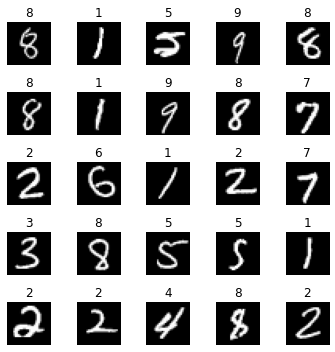

In [17]:
nrows, ncols = 5,5

indices = np.random.randint(len(X), size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5,5))
for i in range(nrows):
    for j in range(ncols):
        idx = indices[i][j]
        ax[i][j].imshow(X[idx], cmap='gray')
        ax[i][j].set_title(f"{y[idx]}")
        ax[i][j].axis('off')
        
plt.tight_layout()
plt.show()

In [18]:
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models

In [29]:
def get_transform(train=True):
    t = list()
    t.append(transforms.ToTensor())
    if crop and train:
        t.append(transforms.RandomResizedCrop(size=28, scale=(.35,1.), ratio=(.5,2), interpolation=transforms.InterpolationMode.NEAREST))
    if rotation and train:
        t.append(transforms.RandomRotation(
        degrees=25, interpolation=transforms.InterpolationMode.NEAREST))
    if normalization:
        t.append(transforms.Normalize(mean=(.5), std=(.5)))
    return transforms.Compose(t)

In [30]:
class CustomDataset(Dataset):
    def __init__(self, X, y=None, transform=None, target_transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        inputs = self.X[idx]
        if transform:
            inputs = self.transform(inputs)
        if self.y is not None:
            labels = self.y[idx]
            if self.target_transform:
                labels = self.target_transform(labels)
            return inputs, labels
        return inputs

In [31]:
transform = get_transform()
transform_test = get_transform(train=False)

In [34]:
transformed_train = CustomDataset(X=X_train, y=y_train, transform=transform)
if validation:
    transformed_valid = CustomDataset(X=X_valid, y=y_valid, transform=transform_test)
transformed_test = CustomDataset(X=X_test, transform=transform_test)

In [ ]:
trainloader = DataLoader(transformed_train, batch_size=batch_size, sh)